# Forecasting 4: Comparing Forecasting Techniques (AutoARIMA)

The following notebook will compare the AutoARIMA, Prophet, and XGBoost models for predicting weather data. The goal of this is to determine weighting for a mixed approach, where forecasts use weighted predictions of each model that are then averaged to produce a (hopefully) more robust measure.

Let's start by importing packages and getting a couple of test datasets, then developing each of the models.

## 1. Importing Packages and Data

### Defining Required Packages and Region Information

In [28]:
import numpy as np
import pandas as pd
import datetime as dt

from backend.regionweather import RegionWeather
from backend.autoarima import AutoARIMAForecast
from backend.prophet import ProphetForecast
from backend.xgb import XGBoostForecast

# Get the weather data for the region
region_data = {
    'US-FLA-FMPP': {'lat': 28.525581, 'lon': -81.536775, 'alt': 0},
    'US-FLA-FPC': {'lat': 28.996695, 'lon': -82.886613, 'alt': 0},
    'US-FLA-FPL': {'lat': 27.917488, 'lon': -81.450970, 'alt': 0},
    'US-FLA-GVL': {'lat': 29.619310, 'lon': -82.328732, 'alt': 0},
    'US-FLA-HST': {'lat': 25.456904, 'lon': -80.588092, 'alt': 0},
    'US-FLA-JEA': {'lat': 30.390902, 'lon': -83.679837, 'alt': 0},
    'US-FLA-SEC': {'lat': 28.805983, 'lon': -82.306291, 'alt': 0},
    'US-FLA-TAL': {'lat': 30.437174, 'lon': -84.248042, 'alt': 0},
    'US-FLA-TEC': {'lat': 27.959413, 'lon': -82.144821, 'alt': 0}
}

### Create RegionWeather Entities

In [29]:
region_name = list(region_data.keys())[0]
region_lat = region_data[region_name]['lat']
region_lon = region_data[region_name]['lon']
region_alt = region_data[region_name]['alt']

end = dt.datetime.now()
start = end - dt.timedelta(days=30)

# Get the weather data for the region
region_weather = RegionWeather(region_name, region_lat, region_lon, region_alt, start, end).to_dict()

fifteen = region_weather['df_15m']
hourly = region_weather['df_hourly']
daily = region_weather['df_daily']

Fetching Hourly Object...
Hourly Object Fetched!
Fetching Hourly Data from Object...
Hourly Object Fetched!
Hourly Data Cleaned!
Fetching Daily Data...
Daily Data Fetched!
Fetching Weekly Data...
Weekly Data Aggregated and Fetched!
Fetching Monthly Data...
Fetching Daily Data...
Monthly Data Fetched!
15 Minute Data Interpolated!


### Create Temperature Objects

Daily Data is still broken for some reason, I'll have to go back and troubleshoot that later...

In [30]:
temp_15m = fifteen['temp'].reset_index().dropna()
temp_15m.columns = ['ds', 'y']
temp_15m['unique_id'] = '1'

temp_hourly = hourly['temp'].reset_index().dropna()
temp_hourly.columns = ['ds', 'y']
temp_hourly['unique_id'] = '2'

In [31]:
temp_15m.head()

,ds,y,unique_id
0,2025-03-02 21:00:00,21.9,1
1,2025-03-02 21:15:00,21.2,1
2,2025-03-02 21:30:00,20.5,1
3,2025-03-02 21:45:00,19.8,1
4,2025-03-02 22:00:00,19.1,1


In [32]:
temp_hourly.head()

,ds,y,unique_id
0,2025-03-02 21:00:00,21.9,2
1,2025-03-02 22:00:00,19.1,2
2,2025-03-02 23:00:00,16.9,2
3,2025-03-03 00:00:00,16.9,2
4,2025-03-03 01:00:00,14.6,2


Now the data has been prepared, and we can move onto testing the forecasting models.

## 2. AutoARIMA

In [33]:
aarima = AutoARIMAForecast(region_name, temp_15m)

Initializing AutoARIMA model for region: US-FLA-FMPP
2025-04-01 20:54:58,639 - AutoARIMAForecast_US-FLA-FMPP - INFO - Initializing AutoARIMA model for region: US-FLA-FMPP
Processing initial dataframe with 2877 rows
2025-04-01 20:54:58,640 - AutoARIMAForecast_US-FLA-FMPP - INFO - Processing initial dataframe with 2877 rows
Fitting AutoARIMA model for region US-FLA-FMPP with 2877 data points...
2025-04-01 20:54:58,641 - AutoARIMAForecast_US-FLA-FMPP - INFO - Fitting AutoARIMA model for region US-FLA-FMPP with 2877 data points
Detecting time series frequency...
2025-04-01 20:54:58,642 - AutoARIMAForecast_US-FLA-FMPP - INFO - Detecting time series frequency
Detected frequency: 15min
2025-04-01 20:54:58,644 - AutoARIMAForecast_US-FLA-FMPP - INFO - Detected frequency: 15min
Determining seasonal period...
2025-04-01 20:54:58,645 - AutoARIMAForecast_US-FLA-FMPP - INFO - Determining seasonal period
Determined season length: 96
2025-04-01 20:54:58,645 - AutoARIMAForecast_US-FLA-FMPP - INFO - Det

Now that the model has been fitted, we can forecast futue data.

In [34]:
forecasts = aarima.forecast(level=[95])
res = aarima.get_results()
summary = aarima.get_model_summary()

Generating forecast for region US-FLA-FMPP for next 96 periods (requested: 96, adjusted based on freq: 15min)...
2025-04-01 21:42:58,699 - AutoARIMAForecast_US-FLA-FMPP - INFO - Generating forecast for region US-FLA-FMPP for next 96 periods (freq: 15min)
Last historical date: 2025-04-01 20:00:00
2025-04-01 21:42:58,702 - AutoARIMAForecast_US-FLA-FMPP - INFO - Last historical date: 2025-04-01 20:00:00
Next forecast timestamp: 2025-04-01 20:15:00
2025-04-01 21:42:58,702 - AutoARIMAForecast_US-FLA-FMPP - INFO - Next forecast timestamp: 2025-04-01 20:15:00
Generated future dates from 2025-04-01 20:15:00 to 2025-04-02 20:00:00
Time difference between last historical and first forecast: 0 days 00:15:00
2025-04-01 21:42:58,702 - AutoARIMAForecast_US-FLA-FMPP - INFO - Generated future dates from 2025-04-01 20:15:00 to 2025-04-02 20:00:00
2025-04-01 21:42:58,703 - AutoARIMAForecast_US-FLA-FMPP - INFO - Time difference between last historical and first forecast: 0 days 00:15:00
Created forecast 

In [35]:
summary

{'region_name': 'US-FLA-FMPP',
 'fitted': True,
 'frequency': '15min',
 'season_length': 96,
 'data_points': 2877,
 'forecast_generated': True,
 'forecast_periods': 96}

Creating forecast plot for region US-FLA-FMPP...
2025-04-01 21:42:58,795 - AutoARIMAForecast_US-FLA-FMPP - INFO - Creating forecast plot for region US-FLA-FMPP
Last historical date: 2025-04-01 20:00:00, value: 30.5
First forecast date: 2025-04-01 20:15:00, value: 30.21981528928881
Time difference: 0 days 00:15:00
2025-04-01 21:42:58,808 - AutoARIMAForecast_US-FLA-FMPP - INFO - Last historical date: 2025-04-01 20:00:00, value: 30.5
2025-04-01 21:42:58,821 - AutoARIMAForecast_US-FLA-FMPP - INFO - First forecast date: 2025-04-01 20:15:00, value: 30.21981528928881
2025-04-01 21:42:58,842 - AutoARIMAForecast_US-FLA-FMPP - INFO - Time difference: 0 days 00:15:00
Added bridge point to create continuous forecast line
2025-04-01 21:42:58,845 - AutoARIMAForecast_US-FLA-FMPP - INFO - Added bridge point to create continuous forecast line
Adding 95% confidence interval to plot...
2025-04-01 21:42:58,846 - AutoARIMAForecast_US-FLA-FMPP - INFO - Adding 95% confidence interval to plot
Forecast plot cr

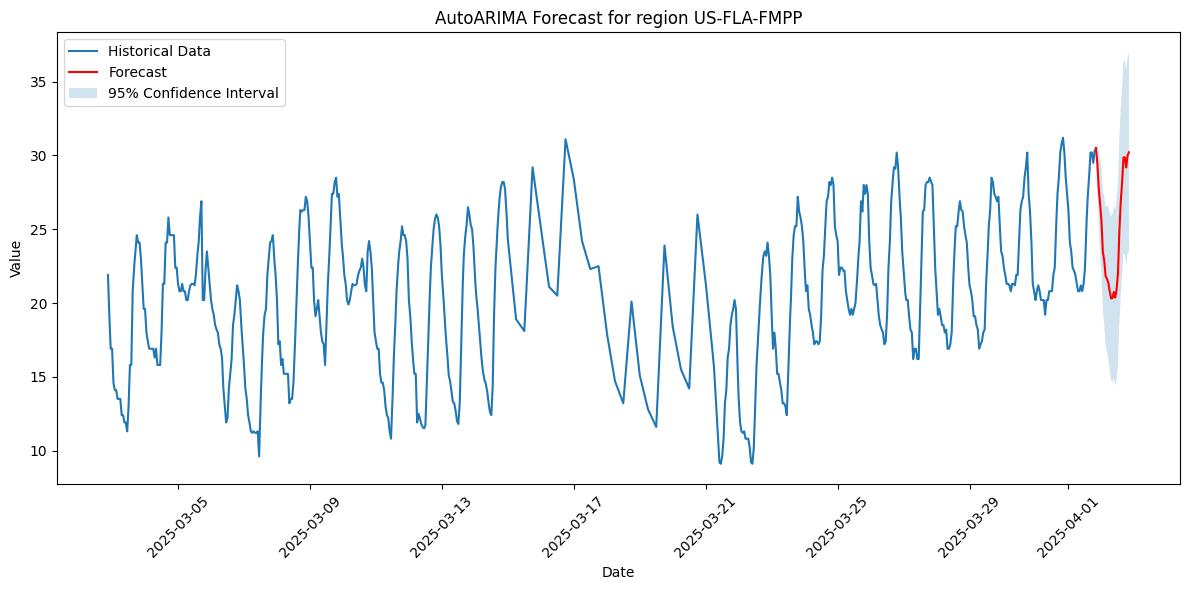

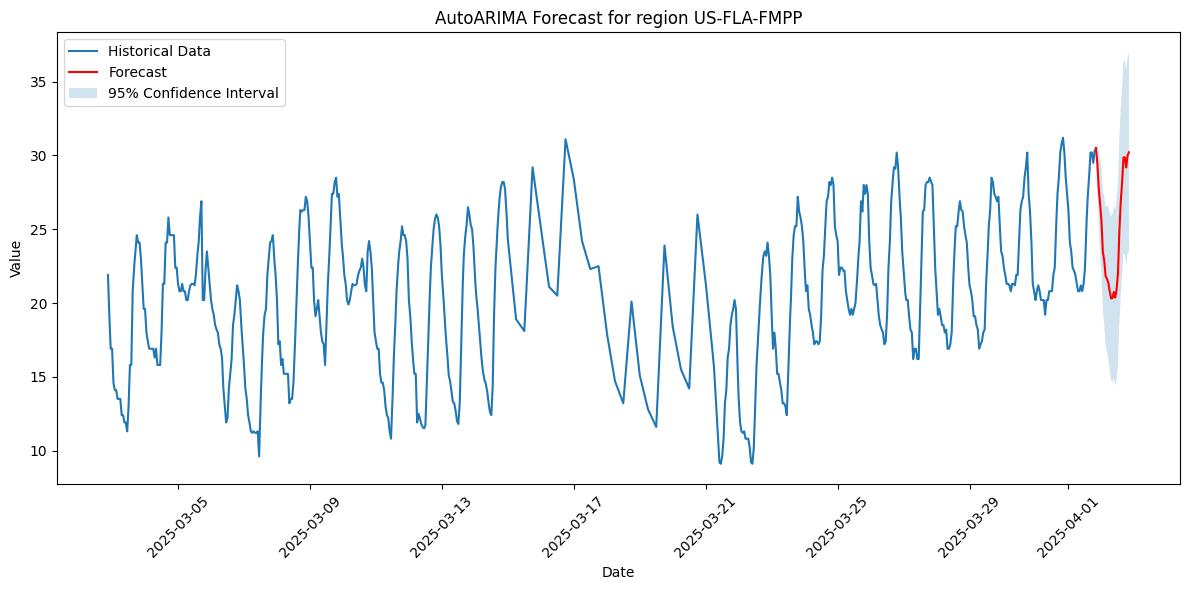

In [36]:
aarima.plot_forecast()

In [37]:
eval_res = aarima.evaluate()
eval_res

Performing cross-validation for region US-FLA-FMPP with h=12, step_size=12, n_windows=5...
2025-04-01 21:42:59,101 - AutoARIMAForecast_US-FLA-FMPP - INFO - Performing cross-validation for region US-FLA-FMPP with h=12, step_size=12, n_windows=5
Executing cross-validation...
2025-04-01 21:42:59,103 - AutoARIMAForecast_US-FLA-FMPP - INFO - Executing cross-validation
Restoring model to original state...
2025-04-01 22:38:00,096 - AutoARIMAForecast_US-FLA-FMPP - INFO - Restoring model to original state


KeyboardInterrupt: 

Now we have a pretty good model according to the metrics. 

(I'll go deeper into this in the article and writeup, I am looking at [this source](<https://medium.com/analytics-vidhya/assessment-of-accuracy-metrics-for-time-series-forecasting-bc115b655705>) for evaluating the metrics)

~~We are going to handle the Prophet and XGBoost models in separate files, because it takes ~30 minutes to run each notebook and I'll be able to run them in parallel that way :p~~ I'm just going to try to do this in one sitting so I dont have to run this and then sit for an hour later.

In [13]:
temp_15m.head()

,ds,y,unique_id
0,2025-03-27 18:00:00,28.200,1
1,2025-03-27 18:15:00,28.275,1
2,2025-03-27 18:30:00,28.350,1
3,2025-03-27 18:45:00,28.425,1
4,2025-03-27 19:00:00,28.500,1


Initializing Prophet model for region: US-FLA-FMPP
2025-04-01 17:55:46,220 - ProphetForecast_US-FLA-FMPP - INFO - Initializing Prophet model for region: US-FLA-FMPP
Processing initial dataframe with 477 rows
2025-04-01 17:55:46,221 - ProphetForecast_US-FLA-FMPP - INFO - Processing initial dataframe with 477 rows
Fitting Prophet model for region US-FLA-FMPP with 477 data points...
2025-04-01 17:55:46,221 - ProphetForecast_US-FLA-FMPP - INFO - Fitting Prophet model for region US-FLA-FMPP with 477 data points
Detecting time series frequency...
2025-04-01 17:55:46,223 - ProphetForecast_US-FLA-FMPP - INFO - Detecting time series frequency
Detected frequency: 15min
2025-04-01 17:55:46,225 - ProphetForecast_US-FLA-FMPP - INFO - Detected frequency: 15min
Determining seasonal period...
2025-04-01 17:55:46,225 - ProphetForecast_US-FLA-FMPP - INFO - Determining seasonal period
Determined season length: 96
2025-04-01 17:55:46,225 - ProphetForecast_US-FLA-FMPP - INFO - Determined season length: 96


17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing


Model fitting complete!
2025-04-01 17:55:46,337 - ProphetForecast_US-FLA-FMPP - INFO - Model fitting complete
Generating forecast for region US-FLA-FMPP for next 96 periods (requested: 96, adjusted based on freq: 15min)...
2025-04-01 17:55:46,338 - ProphetForecast_US-FLA-FMPP - INFO - Generating forecast for region US-FLA-FMPP for next 96 periods (freq: 15min)
Creating future dates dataframe...
2025-04-01 17:55:46,339 - ProphetForecast_US-FLA-FMPP - INFO - Creating future dates dataframe
Generating forecast...
2025-04-01 17:55:46,341 - ProphetForecast_US-FLA-FMPP - INFO - Generating forecast
Forecast generated with 96 future points
2025-04-01 17:55:46,515 - ProphetForecast_US-FLA-FMPP - INFO - Forecast generated with 96 future points
Performing cross-validation for region US-FLA-FMPP with h=12, step_size=12, n_windows=5...
2025-04-01 17:55:46,517 - ProphetForecast_US-FLA-FMPP - INFO - Performing cross-validation for region US-FLA-FMPP with h=12, step_size=12, n_windows=5
Executing Prop

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Computing evaluation metrics...
2025-04-01 17:55:47,745 - ProphetForecast_US-FLA-FMPP - INFO - Computing evaluation metrics
Evaluation complete
2025-04-01 17:55:47,765 - ProphetForecast_US-FLA-FMPP - INFO - Evaluation complete
Creating forecast plot for region US-FLA-FMPP...
2025-04-01 17:55:47,766 - ProphetForecast_US-FLA-FMPP - INFO - Creating forecast plot for region US-FLA-FMPP
Last historical date: 2025-04-01 17:00:00, value: 30.2
First forecast date: 2025-04-01 17:15:00, value: 28.67783375315979
Time difference: 0 days 00:15:00
2025-04-01 17:55:47,776 - ProphetForecast_US-FLA-FMPP - INFO - Last historical date: 2025-04-01 17:00:00, value: 30.2
2025-04-01 17:55:47,776 - ProphetForecast_US-FLA-FMPP - INFO - First forecast date: 2025-04-01 17:15:00, value: 28.67783375315979
2025-04-01 17:55:47,777 - ProphetForecast_US-FLA-FMPP - INFO - Time difference: 0 days 00:15:00
Added bridge point to create continuous forecast line
2025-04-01 17:55:47,782 - ProphetForecast_US-FLA-FMPP - INFO -

17:55:47 - cmdstanpy - INFO - Chain [1] start processing
17:55:47 - cmdstanpy - INFO - Chain [1] start processing
17:55:47 - cmdstanpy - INFO - Chain [1] start processing
17:55:47 - cmdstanpy - INFO - Chain [1] start processing
17:55:47 - cmdstanpy - INFO - Chain [1] start processing
17:55:47 - cmdstanpy - INFO - Chain [1] done processing
17:55:47 - cmdstanpy - INFO - Chain [1] done processing
17:55:47 - cmdstanpy - INFO - Chain [1] done processing
17:55:47 - cmdstanpy - INFO - Chain [1] done processing
17:55:47 - cmdstanpy - INFO - Chain [1] done processing


Forecast plot created successfully
2025-04-01 17:55:47,865 - ProphetForecast_US-FLA-FMPP - INFO - Forecast plot created successfully
Returning model results for US-FLA-FMPP
2025-04-01 17:55:47,891 - ProphetForecast_US-FLA-FMPP - INFO - Returning model results for US-FLA-FMPP
Model summary: {'region_name': 'US-FLA-FMPP', 'fitted': True, 'frequency': '15min', 'season_length': 96, 'data_points': 477, 'forecast_generated': True, 'forecast_periods': 96}
2025-04-01 17:55:47,891 - ProphetForecast_US-FLA-FMPP - INFO - Model summary: {'region_name': 'US-FLA-FMPP', 'fitted': True, 'frequency': '15min', 'season_length': 96, 'data_points': 477, 'forecast_generated': True, 'forecast_periods': 96}


{'region_name': 'US-FLA-FMPP',
 'fitted': True,
 'frequency': '15min',
 'season_length': 96,
 'data_points': 477,
 'forecast_generated': True,
 'forecast_periods': 96}

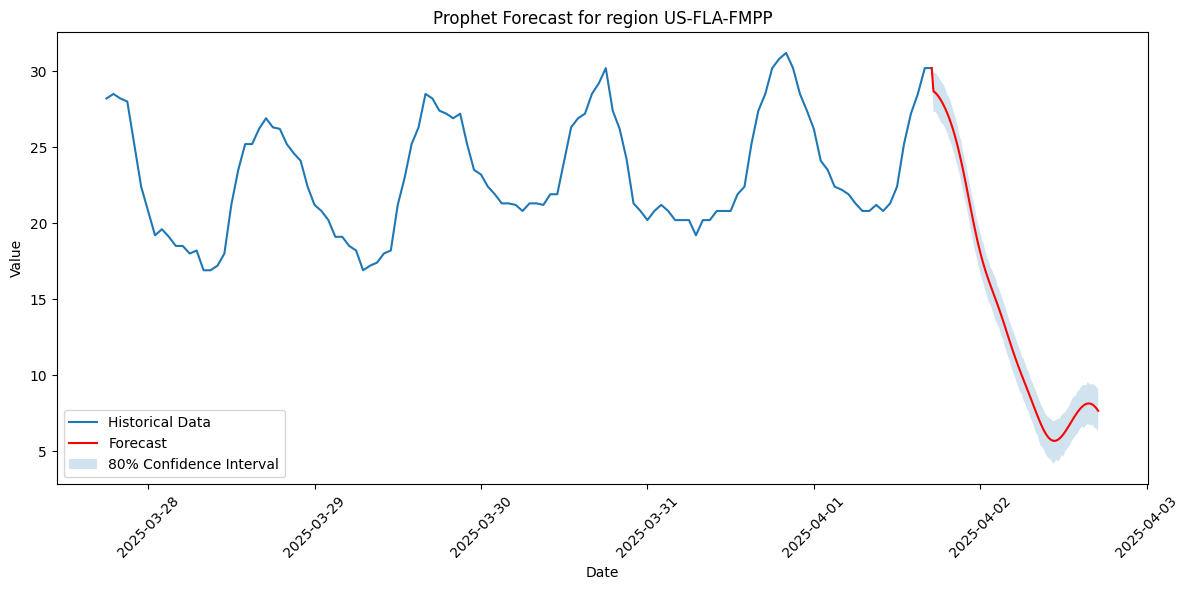

In [17]:
prophet_model = ProphetForecast(region_name, temp_15m)
prophet_model.forecast(level=[95])
prophet_model.evaluate()
prophet_model.plot_forecast()
prophet_model.get_results()
prophet_model.get_model_summary()

In [18]:
prophet_model.evaluate()

Performing cross-validation for region US-FLA-FMPP with h=12, step_size=12, n_windows=5...
2025-04-01 17:58:38,575 - ProphetForecast_US-FLA-FMPP - INFO - Performing cross-validation for region US-FLA-FMPP with h=12, step_size=12, n_windows=5
Executing Prophet cross-validation...
2025-04-01 17:58:38,575 - ProphetForecast_US-FLA-FMPP - INFO - Executing Prophet cross-validation


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Computing evaluation metrics...
2025-04-01 17:58:39,766 - ProphetForecast_US-FLA-FMPP - INFO - Computing evaluation metrics
Evaluation complete
2025-04-01 17:58:39,788 - ProphetForecast_US-FLA-FMPP - INFO - Evaluation complete


17:58:39 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing


,unique_id,metric,value
0,1,mae,1.652199
0,1,mape,0.069915
0,1,mse,3.738023
0,1,rmse,1.933397


Great! The predictions look a little wonky, so I will dive a bit deeper into the predictions once the models have been compared. Let's move onto XGBoost.

## 4. XGBoost Forecasts

In [21]:
xgb = XGBoostForecast(region_name, temp_15m)
xgb.forecast(level=[95])
xgb.evaluate()
xgb.plot_forecast()
xgb.get_results()
xgb.get_model_summary()
xgb.evaluate()

Initializing XGBoost model for region: US-FLA-FMPP
2025-04-01 18:00:15,176 - XGBoostForecast_US-FLA-FMPP - INFO - Initializing XGBoost model for region: US-FLA-FMPP
Processing initial dataframe with 477 rows
2025-04-01 18:00:15,177 - XGBoostForecast_US-FLA-FMPP - INFO - Processing initial dataframe with 477 rows
Fitting XGBoost model for region US-FLA-FMPP with 477 data points...
2025-04-01 18:00:15,905 - XGBoostForecast_US-FLA-FMPP - INFO - Fitting XGBoost model for region US-FLA-FMPP with 477 data points
Detecting time series frequency...
2025-04-01 18:00:15,906 - XGBoostForecast_US-FLA-FMPP - INFO - Detecting time series frequency
Detected frequency: 15min
2025-04-01 18:00:15,909 - XGBoostForecast_US-FLA-FMPP - INFO - Detected frequency: 15min
Determining seasonal period...
2025-04-01 18:00:15,909 - XGBoostForecast_US-FLA-FMPP - INFO - Determining seasonal period
Determined season length: 96
2025-04-01 18:00:15,909 - XGBoostForecast_US-FLA-FMPP - INFO - Determined season length: 96


ValueError: Not enough data points after creating lag features